In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

%matplotlib inline
pd.set_option('display.max_columns', 100)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def one_hot(lst, num_class=4) :
    return np.eye(num_class)[lst]

In [3]:
def making_data(csv) :
    activity = pd.read_csv(csv).drop("Unnamed: 0", axis=1)
    label = activity[["acc_id", "label"]]
    
    activity = activity[activity["label"] != "empty"]
    activity = activity.drop("label", axis=1)
    label = label[label["label"] != "empty"]
    
    activity = activity.sort_values(["acc_id","wk"])[['acc_id', 'wk', 'cnt_clear_bam', 'cnt_clear_inzone_light','cnt_clear_inzone_normal', 
                                                  'cnt_clear_inzone_skilled', 'cnt_clear_inzone_solo', 'cnt_clear_raid', 'cnt_clear_raid_light',
                                                  'cnt_dt', 'cnt_enter_bam', 'cnt_enter_inzone_light', 'cnt_enter_inzone_normal', 
                                                  'cnt_enter_inzone_skilled', 'cnt_enter_inzone_solo', 'cnt_enter_raid', 'cnt_enter_raid_light',
                                                  'cnt_use_buffitem', 'district_chat', 'duel_cnt', 'duel_win', 'faction_chat', 'game_combat_time', 
                                                  'gathering_cnt', 'get_money','guild_chat', 'item_hongmun', 'making_cnt', 'normal_chat', 
                                                  'npc_exp', 'npc_hongmun', 'party_chat', 'partybattle_cnt', 'partybattle_win', 'play_time', 
                                                  'quest_exp', 'quest_hongmun', 'whisper_chat','first_week', 'payment_amount']]
    label = label.sort_values("acc_id")
    
    label_lst = sorted(list(set([tuple(x) for x in label.values])))
    label = pd.DataFrame(label_lst, columns = ["acc_id", "label"])
    
    activity1 = activity[activity["wk"]==1].drop(["acc_id", "wk"], axis=1)
    activity2 = activity[activity["wk"]==2].drop(["acc_id", "wk"], axis=1)
    activity3 = activity[activity["wk"]==3].drop(["acc_id", "wk"], axis=1)
    activity4 = activity[activity["wk"]==4].drop(["acc_id", "wk"], axis=1)
    activity5 = activity[activity["wk"]==5].drop(["acc_id", "wk"], axis=1)
    activity6 = activity[activity["wk"]==6].drop(["acc_id", "wk"], axis=1)
    activity7 = activity[activity["wk"]==7].drop(["acc_id", "wk"], axis=1)
    activity8 = activity[activity["wk"]==8].drop(["acc_id", "wk"], axis=1)
    
    activity = np.concatenate([activity1.values, activity2.values, activity3.values, activity4.values,
                               activity5.values, activity6.values, activity7.values, activity8.values], axis=1)
    
    label_dic = {"week":0 , "month" :1, "2month":2, "retained":3}

    label2 = label.sort_values(by="acc_id")
    label2["label"] = label2["label"].map(lambda x : label_dic[x])
    
    total_lst = activity
    label_dic = label2.label.tolist()
    total_label = one_hot(label_dic)
    
    return total_lst, total_label

<br></br><br></br><br></br>

In [4]:
total_lst, total_label = making_data("OnlyExpanded.csv")

In [5]:
idx1 = len(total_lst)//5 *4

training_lst = np.array(total_lst[:idx1])
valid_lst = np.array(total_lst[idx1:])

training_label = np.array(total_label[:idx1])
valid_label = np.array(total_label[idx1:])

In [6]:
print(np.array(total_lst).shape)
print(np.array(total_label).shape)

(100000, 304)
(100000, 4)


<br></br><br></br><br></br>

# Model

In [20]:
class MLP() :
    def __init__(self, sess, name):
        self.sess = sess
        self.name = name
        
    
    def build(self, batch_size, input_dim, output_dim, num_layer, num_unit, activation) :
        with tf.variable_scope(self.name) :
            
            ## Setting ##
            # input  : ? x input_length x input_dim
            self.X = tf.placeholder(tf.float32, [None, input_dim])
            self.Y = tf.placeholder(tf.float32, [None, output_dim])
            self.learning_rate =  tf.placeholder(tf.float32)
            self.training = tf.placeholder(tf.bool)
            
            self.batch_size = batch_size
            self.output_dim = output_dim
            self.num_layer = num_layer
            self.num_unit = num_unit
            self.activation = activation
            #############
            
            
            ## MLP ##
            layer_lst = []
            layer = tf.layers.dense(self.X, self.num_unit, activation=self.activation)
            layer_lst.append(layer)
            
            for idx in range((self.num_layer-2)//2) :
                dense_layer = tf.concat(layer_lst, axis=1)
                
                norm1 = tf.contrib.layers.layer_norm(dense_layer)
                relu1 = tf.nn.relu(norm1)
                layer1 = tf.layers.dense(relu1, self.num_unit*2)
                
                norm2 = tf.contrib.layers.layer_norm(layer1)
                relu2 = tf.nn.relu(norm2)
                layer2 = tf.layers.dense(relu2, self.num_unit)
                dropout = tf.layers.dropout(layer2, training=self.training)
                
                layer_lst.append(dropout)
                
            layer_lst2 = []
            concat_layer = tf.concat(layer_lst, axis=1)
            batch, hidden = concat_layer.get_shape().as_list()
            
            compression_norm = tf.contrib.layers.layer_norm(concat_layer)
            compression_relu = tf.nn.relu(compression_norm)
            compression_layer = tf.layers.dense(compression_relu, hidden//2)
            layer_lst2.append(compression_layer)
            
            for idx in range((self.num_layer-2)//2) :
                dense_layer2 = tf.concat(layer_lst2, axis=1)
                
                norm1 = tf.contrib.layers.layer_norm(dense_layer2)
                relu1 = tf.nn.relu(norm1)
                layer1 = tf.layers.dense(relu1, self.num_unit*2)
                
                norm2 = tf.contrib.layers.layer_norm(layer1)
                relu2 = tf.nn.relu(norm2)
                layer2 = tf.layers.dense(relu2, self.num_unit)
                dropout = tf.layers.dropout(layer2, training=self.training)
                
                layer_lst2.append(dropout)
            
            concat_layer2 = tf.concat(layer_lst2, axis=1)
            compression_norm2 =tf.contrib.layers.layer_norm(concat_layer2)
            compression_relu2 = tf.nn.relu(compression_norm2)
            compression_layer2 = tf.layers.dense(compression_relu2, self.num_unit)
            layer = tf.layers.dense(compression_layer2, self.output_dim)
            #########################
            
            
            ## Classifier ##
            self.weight = tf.nn.softmax(tf.Variable(tf.random_normal([4])))+tf.ones([4])
            weight_y =  tf.reduce_sum(self.weight * self.Y, axis=1) 
            
            self.logit = layer
            self.softmax = tf.nn.softmax(self.logit)
            self.softmax_logit = tf.nn.softmax_cross_entropy_with_logits(logits=self.logit, labels=self.Y)
            self.softmax_logit_weight = self.softmax_logit * weight_y
            ################
            
            
            ## Learning ##
            self.cost = tf.reduce_sum(self.softmax_logit_weight)

            update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope=self.name)
            with tf.control_dependencies(update_ops):
                self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.cost)
            
            self.prediction = tf.equal(tf.argmax(self.logit, 1), tf.argmax(self.Y, 1))     
            self.accuracy = tf.reduce_mean(tf.cast(self.prediction, tf.float32))    
            ##############
        
        
    def train(self, X_input, Y_input, learning_rate, training=True):
        feed_dict = {self.X: X_input, self.Y: Y_input, self.learning_rate: learning_rate, self.training: training}
        _, cost = self.sess.run([self.optimizer, self.cost], feed_dict=feed_dict)
        
        return _, cost
    
    def predict(self, X_input, training=False):
        feed_dict = {self.X: X_input, self.training: training}
        result = self.sess.run([self.logit], feed_dict=feed_dict)
            
        return result
    
    def evaluate(self, X_input, Y_input):
        size = X_input.shape[0]
            
        total_loss = 0
        total_acc = 0
            
        for idx in range(0, size, self.batch_size):
            X_batch = X_input[idx:idx + batch_size]
            Y_batch = Y_input[idx:idx + batch_size]
            feed_dict = {self.X: X_batch, self.Y: Y_batch, self.training: False}
                
            loss = self.cost
            accuracy = self.accuracy
                
            step_loss, step_acc = self.sess.run([loss, accuracy], feed_dict=feed_dict)
                
            total_loss += step_loss * X_batch.shape[0]
            total_acc += step_acc * X_batch.shape[0]
            
        total_loss /= size
        total_acc /= size
            
        return total_loss, total_acc

In [21]:
tf.reset_default_graph() 

<br></br><br></br><br></br> 

In [22]:
learning_rate1 = 0.02
learning_rate2 = 0.01
learning_rate3 = 0.005
learning_rate4 = 0.001

total_epoch = 100
batch_size = 500
input_dim = np.array(total_lst).shape[1]

In [23]:
idx = 0
model_lst = []

for num_layer in [6,8,10] :
    for num_unit in [256, 512] :
        for activation in [None, tf.nn.relu] :
            print(idx)
            sess = tf.Session()
            model = MLP(sess, "model{}".format(idx))
            model.build(batch_size, input_dim, 4, num_layer, num_unit, activation)
            sess.run(tf.global_variables_initializer())
            
            model_lst.append(model)
            idx+=1
            
tl_ta_vl_va_lst = [[[],[],[],[]]]*len(model_lst)
print("Ready!")

0
1
2
3
4
5
6
7
8
9
10
11
Ready!


In [24]:
print('Learning Started!')
print("")

# train my model
for epoch in range(total_epoch):
    avg_cost = [0]*len(model_lst)
    total_batch = int(len(training_lst) / batch_size)
    idx = 0
    
    if epoch == 0 :
        learning_rate = learning_rate1
    elif epoch == 10 :
        learning_rate = learning_rate2
    elif epoch == 20 :
        learning_rate = learning_rate3
    elif epoch == 80 :
        learning_rate = learning_rate4

    for i in range(total_batch):
        batch_xs, batch_ys = training_lst[idx:idx+batch_size],training_label[idx:idx+batch_size]
        
        for model_num, model in enumerate(model_lst) :
            _, c = model.train(batch_xs, batch_ys, learning_rate)
            avg_cost[model_num] += c / total_batch
        
        idx += batch_size
        if i%10 == 0 :
            print("log :", i)
            
    #train/valid cost & acc
    print("***epoch*** : ", epoch)
    for model_num, model in enumerate(model_lst) :
        train_cost, train_acc = model.evaluate(training_lst, training_label)
        valid_cost, valid_acc = model.evaluate(valid_lst, valid_label)

        tl_ta_vl_va_lst[model_num][0].append(train_cost)
        tl_ta_vl_va_lst[model_num][1].append(train_acc)
        tl_ta_vl_va_lst[model_num][2].append(valid_cost)
        tl_ta_vl_va_lst[model_num][3].append(valid_acc)

        print("-- train {:.5f}({:.1f}%), valid{:.5f}({:.1f}%)".format(train_cost, train_acc*100, valid_cost, valid_acc*100))
    
    for model in model_lst :
        print('Accuracy:', model.evaluate(valid_lst, valid_label)[1])
    for model in model_lst :
        print("Weight:", sess.run(model.weight))
    print(" ")

print("")
print('Learning Finished!')

Learning Started!

log : 0
log : 10
log : 20
log : 30
log : 40
log : 50
log : 60
log : 70
log : 80
log : 90
log : 100
log : 110
log : 120
log : 130
log : 140
log : 150
***epoch*** :  0
-- train 863.25727(56.6%), valid844.95648(57.1%)
-- train 807.64527(52.5%), valid798.46429(52.2%)
-- train 1592.68924(39.0%), valid1572.08626(39.8%)
-- train 927.31740(59.7%), valid916.56170(60.3%)
-- train 1708.00659(42.6%), valid1678.73188(43.4%)
-- train 719.05882(59.2%), valid710.99954(59.6%)
-- train 1124.56436(54.9%), valid1107.33148(55.1%)
-- train 1059.56777(56.7%), valid1068.88067(56.6%)
-- train 830.38985(51.9%), valid813.12367(52.5%)
-- train 1003.19966(42.3%), valid982.22954(42.7%)
-- train 1774.52809(46.1%), valid1756.69759(46.2%)
-- train 1101.51344(47.4%), valid1087.79902(47.6%)
Accuracy: 0.571400000154972
Accuracy: 0.5215000033378601
Accuracy: 0.3977000005543232
Accuracy: 0.6026999995112419
Accuracy: 0.43445000126957894
Accuracy: 0.5959499999880791
Accuracy: 0.5510499946773052
Accuracy: 0

log : 0
log : 10
log : 20
log : 30
log : 40
log : 50
log : 60
log : 70
log : 80
log : 90
log : 100
log : 110
log : 120
log : 130
log : 140
log : 150
***epoch*** :  5
-- train 708.17936(61.1%), valid722.16433(61.2%)
-- train 575.74782(66.5%), valid592.69310(66.3%)
-- train 804.62271(63.6%), valid814.50693(63.5%)
-- train 610.68624(65.7%), valid634.14597(65.4%)
-- train 665.51470(65.4%), valid678.37391(65.1%)
-- train 596.86405(66.3%), valid617.55854(65.9%)
-- train 631.31039(66.5%), valid657.91301(65.9%)
-- train 754.46007(64.1%), valid805.93459(63.3%)
-- train 671.75017(65.2%), valid683.41541(64.9%)
-- train 592.69527(63.8%), valid600.18493(63.8%)
-- train 836.21620(65.4%), valid852.54363(65.1%)
-- train 699.84911(60.1%), valid726.83605(59.5%)
Accuracy: 0.6118499979376792
Accuracy: 0.6629999950528145
Accuracy: 0.6347000002861023
Accuracy: 0.6537000074982643
Accuracy: 0.6505500033497811
Accuracy: 0.6592000007629395
Accuracy: 0.6586000025272369
Accuracy: 0.6327000007033348
Accuracy: 0.64

log : 0
log : 10
log : 20
log : 30
log : 40
log : 50
log : 60
log : 70
log : 80
log : 90
log : 100
log : 110
log : 120
log : 130
log : 140
log : 150
***epoch*** :  10
-- train 634.71176(63.3%), valid667.51729(62.8%)
-- train 524.47846(68.2%), valid566.94420(67.4%)
-- train 756.37904(64.1%), valid788.41231(63.9%)
-- train 538.72327(68.6%), valid592.59204(67.8%)
-- train 553.55932(68.2%), valid595.70807(67.5%)
-- train 534.63327(68.6%), valid579.16582(67.8%)
-- train 570.07888(69.3%), valid622.71700(68.2%)
-- train 635.39831(68.5%), valid721.12625(67.6%)
-- train 503.26595(68.6%), valid531.97092(67.8%)
-- train 542.55100(68.3%), valid578.84453(67.7%)
-- train 829.22000(68.6%), valid874.83210(67.9%)
-- train 547.32606(67.5%), valid604.16847(66.1%)
Accuracy: 0.6280000045895576
Accuracy: 0.6737499952316284
Accuracy: 0.6387500017881393
Accuracy: 0.6779999986290932
Accuracy: 0.675349996984005
Accuracy: 0.6778499975800514
Accuracy: 0.6823999986052514
Accuracy: 0.6758499965071678
Accuracy: 0.67

log : 0
log : 10
log : 20
log : 30
log : 40
log : 50
log : 60
log : 70
log : 80
log : 90
log : 100
log : 110
log : 120
log : 130
log : 140
log : 150
***epoch*** :  15
-- train 622.81337(63.6%), valid675.02517(63.1%)
-- train 540.50169(68.3%), valid618.27956(66.9%)
-- train 728.90478(65.3%), valid785.96657(65.0%)
-- train 509.11151(69.3%), valid615.11733(67.9%)
-- train 537.32555(69.7%), valid616.45640(68.4%)
-- train 541.58860(69.4%), valid620.05762(68.0%)
-- train 545.09818(69.2%), valid645.75439(67.5%)
-- train 589.35770(69.8%), valid747.08686(68.0%)
-- train 471.81416(69.2%), valid519.21961(68.2%)
-- train 506.03923(68.7%), valid565.83131(67.7%)
-- train 749.94996(69.1%), valid826.28779(67.9%)
-- train 510.03306(67.5%), valid598.45208(65.7%)
Accuracy: 0.6309000045061112
Accuracy: 0.6693500027060508
Accuracy: 0.6496999993920326
Accuracy: 0.6786000013351441
Accuracy: 0.6838000014424324
Accuracy: 0.6804000020027161
Accuracy: 0.6750999987125397
Accuracy: 0.6797500014305115
Accuracy: 0.6

log : 0
log : 10
log : 20
log : 30
log : 40
log : 50
log : 60
log : 70
log : 80
log : 90
log : 100
log : 110
log : 120
log : 130
log : 140
log : 150
***epoch*** :  20
-- train 612.94514(64.5%), valid699.24617(63.2%)
-- train 484.99106(69.8%), valid612.48925(67.8%)
-- train 744.78632(66.7%), valid848.96142(65.7%)
-- train 474.70870(70.3%), valid631.38900(68.3%)
-- train 511.24342(70.7%), valid627.85749(69.1%)
-- train 487.78673(70.8%), valid615.10299(68.9%)
-- train 533.98250(70.3%), valid691.60576(68.2%)
-- train 539.41984(71.2%), valid789.67461(68.3%)
-- train 455.38058(70.4%), valid528.95873(69.1%)
-- train 497.36274(70.1%), valid594.93770(68.7%)
-- train 649.96768(70.1%), valid757.51302(68.4%)
-- train 508.05085(67.7%), valid639.87155(65.6%)
Accuracy: 0.6317499980330468
Accuracy: 0.6781999960541725
Accuracy: 0.6572499990463256
Accuracy: 0.6832500010728836
Accuracy: 0.6910999998450279
Accuracy: 0.6892000004649163
Accuracy: 0.6818000018596649
Accuracy: 0.6827999994158744
Accuracy: 0.6

log : 0
log : 10
log : 20
log : 30
log : 40
log : 50
log : 60
log : 70
log : 80
log : 90
log : 100


KeyboardInterrupt: 

 <br></br><br></br><br></br> 

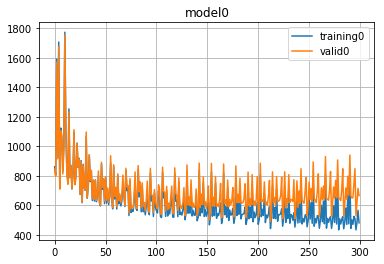

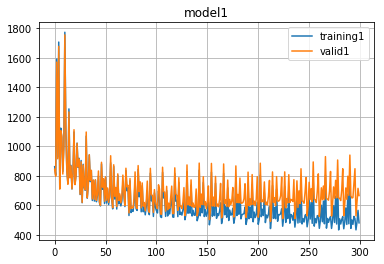

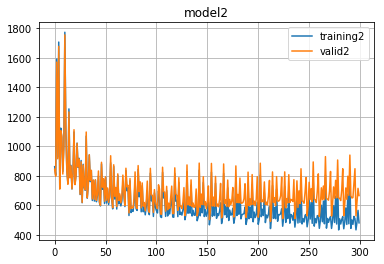

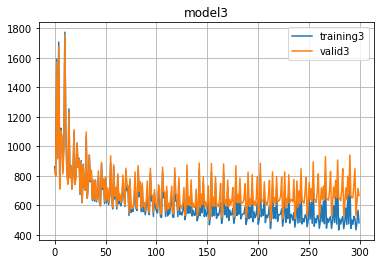

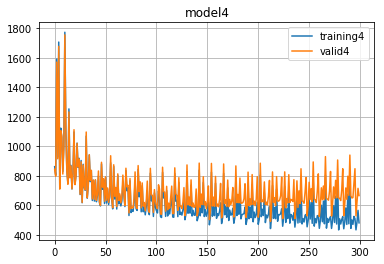

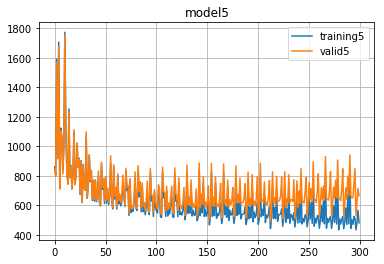

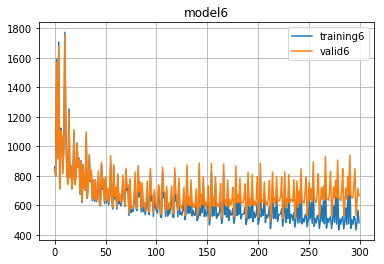

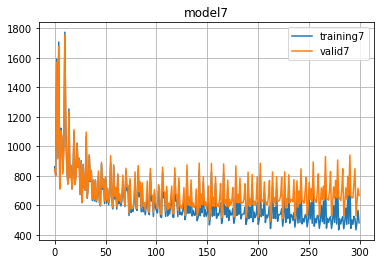

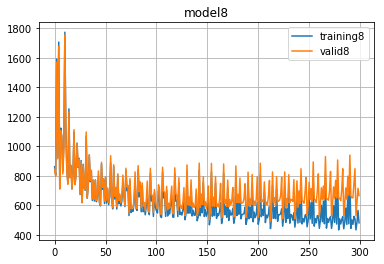

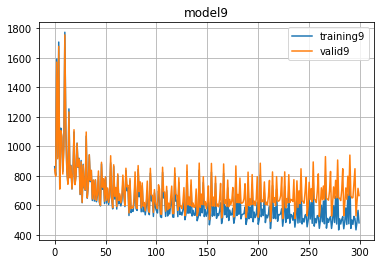

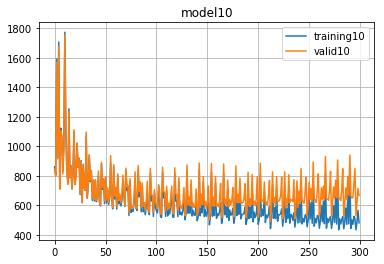

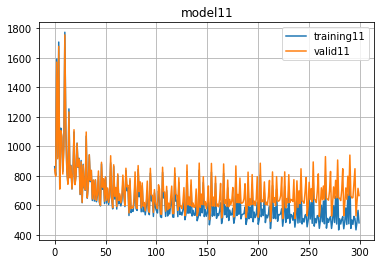

In [25]:
for idx in range(len(model_lst)) :
    plt.plot(tl_ta_vl_va_lst[idx][0], label='training'+str(idx))
    plt.plot(tl_ta_vl_va_lst[idx][2], label='valid'+str(idx))
    plt.title("model"+str(idx))
    plt.grid("on")
    plt.legend()
    plt.show()

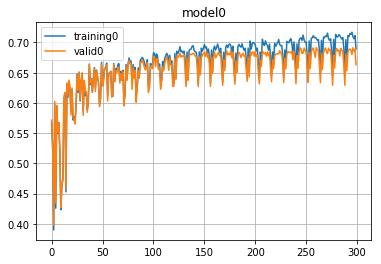

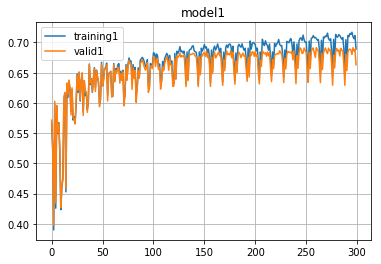

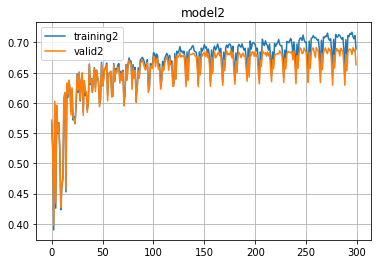

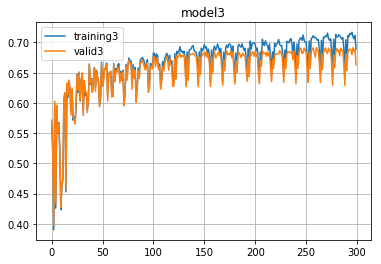

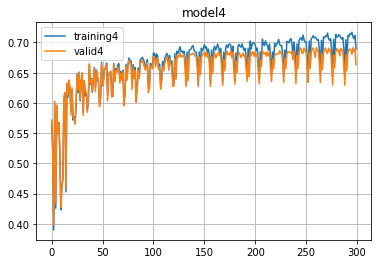

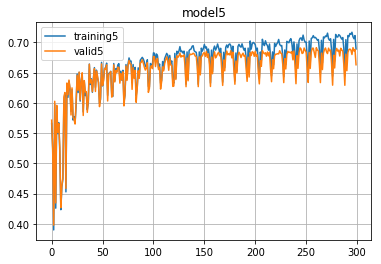

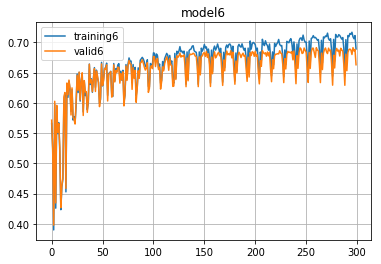

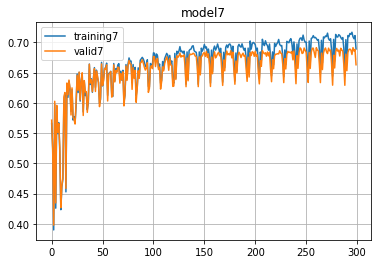

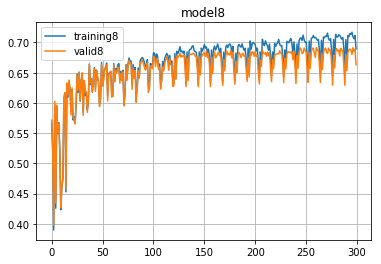

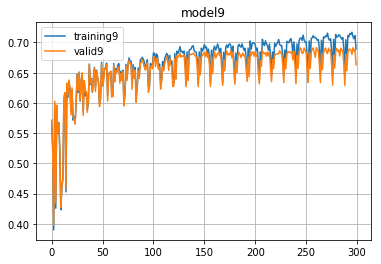

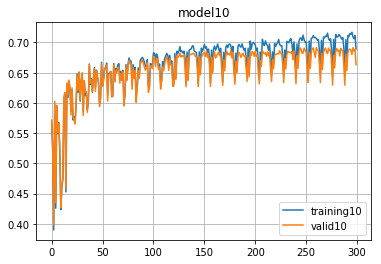

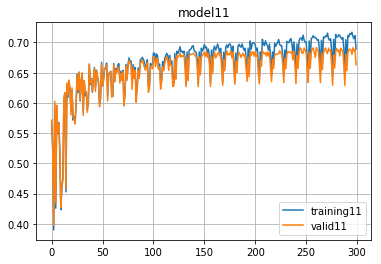

In [26]:
for idx in range(len(model_lst)) :
    plt.plot(tl_ta_vl_va_lst[idx][1], label='training'+str(idx))
    plt.plot(tl_ta_vl_va_lst[idx][3], label='valid'+str(idx))
    plt.title("model"+str(idx))
    plt.grid("on")
    plt.legend()
    plt.show()

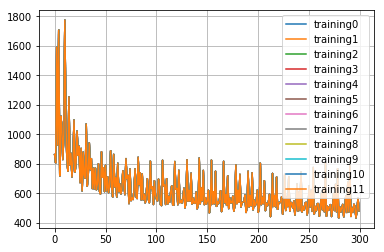

In [27]:
for idx in range(len(model_lst)) :
    plt.plot(tl_ta_vl_va_lst[idx][0], label='training'+str(idx))
    
plt.grid("on")
plt.legend()
plt.show()

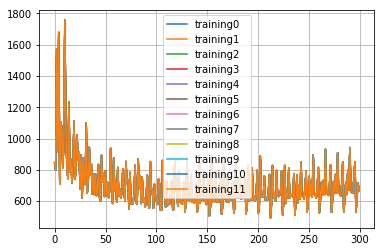

In [28]:
for idx in range(len(model_lst)) :
    plt.plot(tl_ta_vl_va_lst[idx][2], label='training'+str(idx))
    
plt.grid("on")
plt.legend()
plt.show()

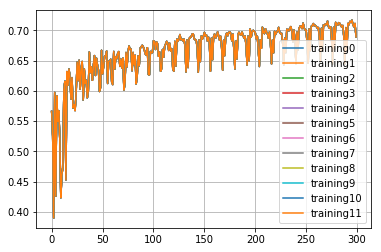

In [29]:
for idx in range(len(model_lst)) :
    plt.plot(tl_ta_vl_va_lst[idx][1], label='training'+str(idx))
    
plt.grid("on")
plt.legend()
plt.show()

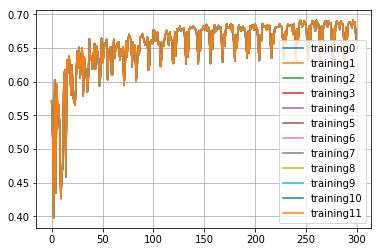

In [30]:
for idx in range(len(model_lst)) :
    plt.plot(tl_ta_vl_va_lst[idx][3], label='training'+str(idx))
    
plt.grid("on")
plt.legend()
plt.show()

<br></br><br></br><br></br>  

In [ ]:
#tf.reset_default_graph() 

In [364]:
saver = tf.train.Saver()

for idx, model in enumerate(model_lst) :
    saver.save(model.sess, './model/MLP_dense_model_{}'.format(idx))

print("Saved!")

'./advanced_RNN/original_user_vector/original'

<br></br><br></br><br></br>

# Test

In [31]:
def making_data(csv) :
    activity = pd.read_csv(csv).drop("Unnamed: 0", axis=1)
    
    activity = activity[activity["label"] == "empty"]
    activity = activity.drop("label", axis=1)
    
    activity = activity.sort_values(["acc_id","wk"])[['acc_id', 'wk', 'cnt_clear_bam', 'cnt_clear_inzone_light','cnt_clear_inzone_normal', 
                                                  'cnt_clear_inzone_skilled', 'cnt_clear_inzone_solo', 'cnt_clear_raid', 'cnt_clear_raid_light',
                                                  'cnt_dt', 'cnt_enter_bam', 'cnt_enter_inzone_light', 'cnt_enter_inzone_normal', 
                                                  'cnt_enter_inzone_skilled', 'cnt_enter_inzone_solo', 'cnt_enter_raid', 'cnt_enter_raid_light',
                                                  'cnt_use_buffitem', 'district_chat', 'duel_cnt', 'duel_win', 'faction_chat', 'game_combat_time', 
                                                  'gathering_cnt', 'get_money','guild_chat', 'item_hongmun', 'making_cnt', 'normal_chat', 
                                                  'npc_exp', 'npc_hongmun', 'party_chat', 'partybattle_cnt', 'partybattle_win', 'play_time', 
                                                  'quest_exp', 'quest_hongmun', 'whisper_chat','first_week', 'payment_amount']]
    
    activity1 = activity[activity["wk"]==1].drop(["acc_id", "wk"], axis=1)
    activity2 = activity[activity["wk"]==2].drop(["acc_id", "wk"], axis=1)
    activity3 = activity[activity["wk"]==3].drop(["acc_id", "wk"], axis=1)
    activity4 = activity[activity["wk"]==4].drop(["acc_id", "wk"], axis=1)
    activity5 = activity[activity["wk"]==5].drop(["acc_id", "wk"], axis=1)
    activity6 = activity[activity["wk"]==6].drop(["acc_id", "wk"], axis=1)
    activity7 = activity[activity["wk"]==7].drop(["acc_id", "wk"], axis=1)
    activity8 = activity[activity["wk"]==8].drop(["acc_id", "wk"], axis=1)
    
    label = activity["acc_id"].values
    activity = np.concatenate([activity1.values, activity2.values, activity3.values, activity4.values,
                               activity5.values, activity6.values, activity7.values, activity8.values], axis=1)

    total_lst = activity
    return total_lst, label

In [32]:
test_data, test_acc_id = making_data("OnlyExpanded.csv")

In [33]:
print(test_data.shape)

(40000, 304)


<br></br><br></br><br></br> 

# Predict

In [34]:
result = []
for model in model_lst :
    result.append(np.argmax(model.predict(test_data), axis=2)) 
    
result = list(map(lambda x : x.tolist()[0], result))
for r_lst in result :
    print("week: {}, month: {}, 2month: {}, retained: {}".format(r_lst.count(0), r_lst.count(1), r_lst.count(2), r_lst.count(3)))

week: 5911, month: 6982, 2month: 16423, retained: 10684
week: 11984, month: 8590, 2month: 6143, retained: 13283
week: 11324, month: 3481, 2month: 9197, retained: 15998
week: 12125, month: 6841, 2month: 8123, retained: 12911
week: 11909, month: 3948, 2month: 12316, retained: 11827
week: 12251, month: 4219, 2month: 11895, retained: 11635
week: 11493, month: 4543, 2month: 10592, retained: 13372
week: 10277, month: 11746, 2month: 6023, retained: 11954
week: 11752, month: 3970, 2month: 13205, retained: 11073
week: 11245, month: 3880, 2month: 11564, retained: 13311
week: 12145, month: 5585, 2month: 10270, retained: 12000
week: 11261, month: 14378, 2month: 1765, retained: 12596


In [35]:
label_df = pd.DataFrame(sorted(list(set(list(test_acc_id))))).rename(columns = {0 : "acc_id"})
result_df = pd.DataFrame(result).T

In [36]:
result_df2 = pd.concat([label_df, result_df], axis=1)
result_df2.head()

,acc_id,0,1,2,3,4,5,6,7,8,9,10,11
0,0002a56a036206aea3a6c6ebc985df4a2d1987b562e7f0...,2,2,2,2,2,2,2,2,2,2,2,1
1,0003bfdebe2b5d46217e8fa5ab0f33cf186fb558435f20...,3,0,0,0,0,0,0,0,0,0,0,0
2,0008f5dce798aaac3f0b05f8a4269cf2052c9b8c5bd911...,2,2,2,2,2,2,2,2,2,2,2,1
3,000cacd86bddabebef813351455304df5493cd71a3d1d2...,2,2,2,2,2,2,2,2,2,2,2,1
4,000ef0765596ac6a6a0a62654895e4673825b6102c7f41...,2,1,3,3,2,2,3,2,2,3,2,3
